## Import MIR-1K Dataset

The dataset can be found https://sites.google.com/site/unvoicedsoundseparation/mir-1k

In [4]:
from scipy import signal
from scipy.io import wavfile
import glob, os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [6]:
songs = []
fs = 10e3
for file in os.listdir('./MIR-1K/Wavfile'):
    if file.endswith('.wav'):
        fs, data = wavfile.read(os.path.join("./MIR-1K/Wavfile",file))
        songs.append(data)

In [27]:
import numpy as np
from sklearn.decomposition import TruncatedSVD


def rpca(M,lam):

    # Cian Scannell - Oct-2017  
    # computes rpca separation of M into L and S using the parameter lam

    # this uses the alternating directions augmented method of multipliers
    # as described in my blog 


    Nr = M.shape[0]
    Nc = M.shape[1]
    Nt = M.shape[2]
    M = M.reshape(Nr*Nc,Nt)

    Y = M / np.maximum(np.linalg.norm(M,2), np.linalg.norm(M,np.inf) / lam)


    mu = 1/ (np.linalg.norm(M,2))
    rho = 1.6


    S = np.zeros((Nr*Nc,Nt))    

    error = 10
    count = 0
    while error > 1e-7:
        U,sig,V = np.linalg.svd(M-S+Y/mu, full_matrices=False)
        L = np.dot(U, np.dot(np.diag(soft_thres(sig, 1/mu)), V))
        S = soft_thres(M-L+Y/mu, lam/mu)
        Y = Y + mu*(M-L-S)
        mu = mu*rho
        error = np.linalg.norm(M-L-S,'fro') / np.linalg.norm(M,'fro')
        count += 1 


    L = L.reshape(Nr,Nc,Nt)
    S = S.reshape(Nr,Nc,Nt)

    # used to previously return count also
    # but don't really use this

    return L,S

def soft_thres(x,eps):

    # Cian Scannell - Oct-2017  

    # soft thresholds a matrix x at the eps level
    # i.e ST(x,eps)_ij = sgn(x_ij) max(|x_ij| - eps, 0)

    a = np.sign(x)
    b = np.maximum((np.fabs(x) - eps), 0)
    return np.multiply(a,b)


In [15]:
try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * self.norm_p(self.D, 2))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def norm_p(M, p):
        return np.sum(np.power(M, p))

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.norm_p(np.abs(self.D), 2)

        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = self.norm_p(np.abs(self.D - Lk - Sk), 2)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

In [8]:
f, t, Zxx = signal.stft(songs[0], fs)

/Users/rachelmoon/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 2, using nperseg = 2
  .format(nperseg, input_length))


In [30]:
Zxx.shape

(107009, 2, 3)

In [28]:
L, S = rpca(Zxx, 1)

TypeError: ufunc 'fabs' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [19]:
rpca = R_pca(Zxx)
L, S = rpca.fit(max_iter=10000, iter_print=100)

# visually inspect results (requires matplotlib)
rpca.plot_fit()
plt.show()

ValueError: shapes (107009,2,2) and (107009,3) not aligned: 2 (dim 2) != 107009 (dim 0)

ValueError: too many values to unpack (expected 2)

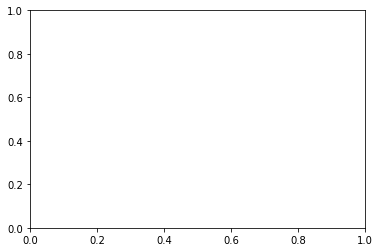

In [31]:
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=9)